In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
import shap
from tqdm.notebook import tqdm

tf.random.set_seed(1234)
tf.keras.utils.set_random_seed(1234)



# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


In [2]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

test_columns = pd.read_csv('baseline_feature_importance.csv', header=None, names=['feature','mae'])
test_columns = test_columns.iloc[1:10,0]
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
first_column = df.pop('SE1')
test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
df = df[test_columns]
print(df.columns)

  
df.insert(0, 'SE1', first_column)

# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1
print(n_features)
features = df.columns[1:]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['Gas', 'Sveriges Förbrukning MWh', 'Summa Vindkraft',
       'Summa Vattenkraft', 'Summa kärnkraft', 'Summa Värmekraft',
       'Summa Ospecificerat', 'Summa Solkraft', 'Sveriges Produktion MWh'],
      dtype='object')
(202878, 10)
9


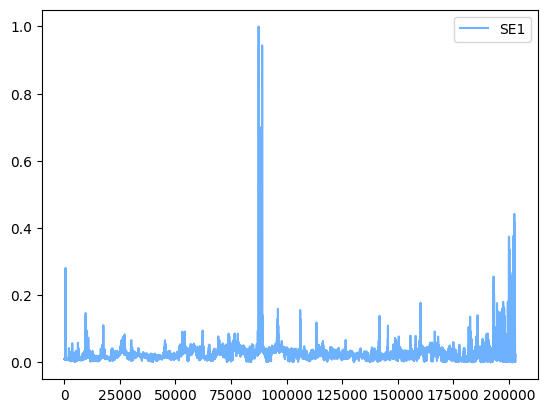

In [3]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [4]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 10)
(20287, 10)
(10143, 10)


In [5]:

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df[:,1:], (train_df.shape[0], 1, train_df.shape[1]-1))
y_train = train_df[:,0]
print(y_train.shape)
X_val = np.reshape(val_df[:,1:], (val_df.shape[0], 1, val_df.shape[1]-1))
y_val = val_df[:,0]
X_test = np.reshape(test_df[:,1:], (test_df.shape[0], 1, test_df.shape[1]-1))
y_test = test_df[:,0]
# X_train = np.array(train_df.iloc[:,1:])
# y_train = np.array(train_df.iloc[:,0])
# X_val = np.array(val_df.iloc[:,1:])
# y_val = np.array(val_df.iloc[:,0])
# X_test = np.array(test_df.iloc[:,1:])
# y_test = np.array(test_df.iloc[:,0])
# sequence_length = 1
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print(X_test.shape)
# print(y_test.shape)
# # Define the sequence length for the LSTM model
# sequence_length = 10

# def create_sequences(df, sequence_length):
#     X = []
#     y = []
#     for i in range(len(df) - sequence_length):
#         X.append(df.iloc[i:i+sequence_length, 1:].values)
#         y.append(df.iloc[i+sequence_length, 0])
#     return np.array(X), np.array(y)


# X_train, y_train = create_sequences(train_df, sequence_length)
# X_val, y_val = create_sequences(val_df, sequence_length)
# X_test, y_test = create_sequences(test_df, sequence_length)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

(172448,)


In [6]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172448, 1, 9)
(172416, 1, 9)
(172416,)


(172416,)


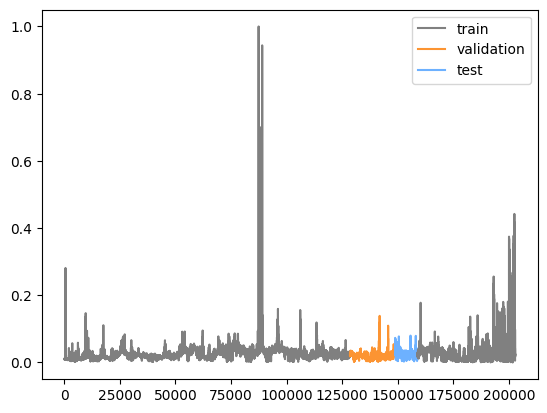

In [7]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [8]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])


In [9]:

def compile_and_fit(model, X_train, y_train, X_val, y_val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  model.build(X_train.shape)
  # print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=0,
                      callbacks=[early_stopping])
  return history

# Data Analysis functions

feature_cutoff: Plot and calculate data cutoff based on mae impact

In [10]:
def feature_cutoff(df, baseline_mae, n_cols, iteration, cutoff = 0, prime = 0):
    # DISPLAY LSTM FEATURE IMPORTANCE
    df = pd.read_csv(iteration + '_feature_importance.csv', header=None, names=['feature','mae'])
    df = df.sort_values('mae')

    plt.figure(figsize=(10,20))
    plt.barh(np.arange(n_cols + 1),df.mae, color='#6db1ff')
    plt.yticks(np.arange(n_cols + 1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,n_cols + 1))

    plt.plot([baseline_mae,baseline_mae],[-1,n_cols + 1], '--', color='orange',
                label=f'Baseline \nMAE={baseline_mae:.4f}')
    a_set_columns = [] 
    b_set_columns = []
    prime_set_columns = []

    df = df[df.feature != 'Baseline']

    if cutoff != 0:
        if cutoff == 1:
            cutoff = np.std(df).mae
        a_set_columns = df[df['mae'] >= baseline_mae - cutoff].feature
        b_set_columns = df[df['mae'] < baseline_mae - cutoff].feature
        plt.plot([baseline_mae-cutoff,baseline_mae-cutoff],[-1,n_cols+1], '--', color='red',
                    label=f'Cutoff threshold\nMAE={baseline_mae-cutoff:.4f}')

    if prime != 0:
        if prime == 1:
            prime = np.std(df).mae
        prime_set_columns = df[df['mae'] > baseline_mae + cutoff].feature
        plt.plot([baseline_mae+cutoff,baseline_mae+cutoff],[-1,n_cols], '--', color='green',
                    label=f'Cutoff threshold\nMAE={baseline_mae+cutoff:.4f}')

    plt.xlabel(f'MAE with feature zeroed',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    return a_set_columns, b_set_columns, prime_set_columns

boxplot: Create a boxplot

In [11]:
def boxplot(data, columns):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, columns.shape[0]//6))

    meds = data.median()
    meds.sort_values(ascending=False, inplace=True)
    data = data[meds.index]

    # rectangular box plot
    bplot1 = ax1.boxplot(data,
                        vert=False,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=columns)  # will be used to label x-ticks

    for patch in bplot1['boxes']:
        patch.set_facecolor('#6db1ff')
    plt.show()

feature_importance: Calculate feature importance

In [12]:
import os
def feature_importance(model, X, y, df, batch_size, iteration):
    COLS = list(df.columns[1:])
    n_cols = len(COLS)
    # n_cols = 5
    print('Computing LSTM feature importance...')

    oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y ))
    print(baseline_mae)
    if os.path.exists(iteration + '_feature_importance.csv'):
        os.remove(iteration + '_feature_importance.csv')
    fi_df = pd.DataFrame(['Baseline', baseline_mae]).T
    fi_df.to_csv(iteration + '_feature_importance.csv', index=False, header=False)
    for k in range(n_cols):
        save_col = X[:,:,k].copy()
        X[:,:,k] = np.zeros((X.shape[0],X.shape[1]))
                
        oof_preds = model.predict(X, verbose=0, batch_size=batch_size).squeeze() 
        mae = np.mean(np.abs( oof_preds-y ))
        fi_df = pd.DataFrame([COLS[k], mae]).T
        fi_df.to_csv(iteration + '_feature_importance.csv', mode='a', index=False, header=False)
        X[:,:,k] = save_col
    
    return baseline_mae, n_cols


# Zeroing feature importance 

In [14]:
compile_and_fit(model, X_train, y_train, X_val, y_val)

In [34]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train[:128])
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
print(explainer.shap_values(X_val[:256]))
shap_values = explainer.shap_values(X_val[:256])
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features) 

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


TypeError: 'NoneType' object cannot be interpreted as an integer